<a href="https://colab.research.google.com/github/UoB-DSMP-2023-24/dsmp-2024-group22/blob/main/TapesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.cloud import storage
gcs = storage.Client()

In [5]:
import pandas as pd
import io

bucket_name = 'jpm-tapes'
directory_path = 'Tapes/'

bucket = gcs.get_bucket(bucket_name)

In [6]:
blobs = bucket.list_blobs(prefix=directory_path)

dfs = []

for blob in blobs:
    if blob.name.endswith('.csv'):
        content = blob.download_as_string()
        df = pd.read_csv(io.BytesIO(content), delimiter='\t', header=None)  # Assuming data is tab-separated
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df = combined_df[0].str.split(', ', expand=True)

combined_df.columns = ['Times', 'price', 'number']


In [7]:
print(combined_df.head())

    Times price number
0  10.881   267      1
1  11.067   269      1
2  11.222   267      2
3  12.338   270      2
4  13.733   267      3


In [10]:
print(combined_df.tail())

             Times price number
3340496  30594.706   108      2
3340497  30595.481   108      2
3340498  30596.349   108      3
3340499  30596.597   108      2
3340500  30596.597   107      2


In [16]:
!pip install transformers
!pip install torch torchvision torchtext
!pip install pytorch-forecasting

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 1

In [35]:
# Check the data types and missing values in the DataFrame
print(combined_df.info())

# Handle any missing values
combined_df.dropna(inplace=True)

# Ensure all columns have numerical data types
combined_df = combined_df.apply(pd.to_numeric, errors='coerce')

# Check the DataFrame after preprocessing
print(combined_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340501 entries, 0 to 3340500
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Times   float64
 1   price   object 
 2   number  float64
dtypes: float64(2), object(1)
memory usage: 76.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340501 entries, 0 to 3340500
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Times   float64
 1   price   int64  
 2   number  float64
dtypes: float64(2), int64(1)
memory usage: 76.5 MB
None


In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define your Temporal Fusion Transformer model
def create_tft_model(input_shape, output_shape):
    input_layer = Input(shape=(input_shape,), name='input_layer')
    lstm_layer = LSTM(64)(Reshape((1, input_shape))(input_layer))
    dense1 = Dense(64, activation='relu')(lstm_layer)
    dropout1 = Dropout(0.2)(dense1)
    output_layer = Dense(output_shape, activation='linear')(dropout1)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Preprocessing the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[['Times', 'number']])
X = np.concatenate([scaled_features, combined_df['price'].values[:, np.newaxis]], axis=1)
y = combined_df['price'].values

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and compile the model
model = create_tft_model(input_shape=X_train.shape[1], output_shape=1)
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# Train the model
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Make predictions
predictions = model.predict(X_test)


Epoch 1/3
66810/66810 [==============================] - 246s 4ms/step - loss: 656.5386 - mean_absolute_error: 17.5351 - val_loss: 47.2976 - val_mean_absolute_error: 6.4711
Epoch 2/3
66810/66810 [==============================] - 247s 4ms/step - loss: 423.0689 - mean_absolute_error: 14.8345 - val_loss: 41.1597 - val_mean_absolute_error: 4.8959
Epoch 3/3
20879/20879 [==============================] - 40s 2ms/step - loss: 16.8501 - mean_absolute_error: 3.1914
Test Loss: 16.850069046020508, Test MAE: 3.191419839859009
20879/20879 [==============================] - 39s 2ms/step


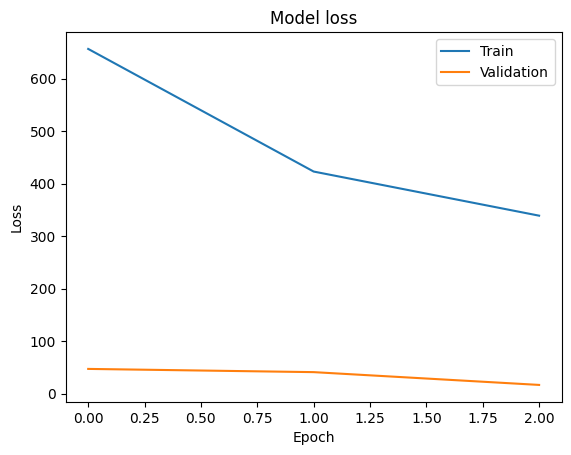

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [42]:
!pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

print(GOOG)

              Open    High     Low   Close    Volume
2004-08-19  100.00  104.06   95.96  100.34  22351900
2004-08-20  101.01  109.08  100.50  108.31  11428600
2004-08-23  110.75  113.48  109.05  109.40   9137200
2004-08-24  111.24  111.60  103.57  104.87   7631300
2004-08-25  104.96  108.00  103.88  106.00   4598900
...            ...     ...     ...     ...       ...
2013-02-25  802.30  808.41  790.49  790.77   2303900
2013-02-26  795.00  795.95  784.40  790.13   2202500
2013-02-27  794.80  804.75  791.11  799.78   2026100
2013-02-28  801.10  806.99  801.03  801.20   2265800
2013-03-01  797.80  807.14  796.15  806.19   2175400

[2148 rows x 5 columns]


In [47]:
class SmaCross(Strategy):
    n1 = 10
    n2 = 30

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


In [48]:
bt = Backtest(df, SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

ValueError: `data` must be a pandas.DataFrame with columns 'Open', 'High', 'Low', 'Close', and (optionally) 'Volume'

In [ ]:
output = bt.run()
print(output)

In [ ]:
bt.plot()